In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Hyperparameter

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
lr = 0.0001
num_workers = 0
img_shape = (1, 28, 28)
g_input_dim = 100
num_epochs = 150
clip_value = 0.01
n_critic= 5

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])

In [4]:
train_data = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size= batch_size, num_workers= num_workers)

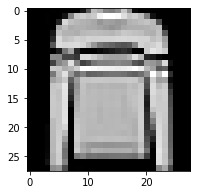

In [5]:
def visualize(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    images = images / 2 + 0.5  
    images = images.numpy()
    
    #get one image in batch
    img = np.squeeze(images[5])
    fig = plt.figure(figsize = (3,3)) 
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')

visualize(train_loader)

## Define the model

### Generator

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(g_input_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        #img = img.view(img.shape[0], *img_shape)
        return img

### Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [8]:
G = Generator().to(device)
D = Discriminator().to(device)

print(G)
print(D)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)

## Define Optimizers

In [9]:
d_optimizer = optim.RMSprop(D.parameters(), lr)
g_optimizer = optim.RMSprop(G.parameters(), lr)

## Training

In [10]:
D.train()
G.train()
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        #TRAIN DISCRIMINATOR
        d_optimizer.zero_grad()

        z = np.random.uniform(-1, 1, size= (batch_size, g_input_dim))
        z = torch.from_numpy(z).float().to(device)
        fake_images = G(z)

        d_loss = torch.mean(D(fake_images)) - torch.mean(D(real_images))

        d_loss.backward()
        d_optimizer.step()

        for p in D.parameters():
            p.data.clamp_(-clip_value, clip_value)

        if i%n_critic == 0:
            g_optimizer.zero_grad()

            fake_images = G(z)
            g_loss = -torch.mean(D(fake_images))

            g_loss.backward()
            g_optimizer.step()
    print("[Epoch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, num_epochs, d_loss.item(), g_loss.item()))

[Epoch 0/150] [D loss: -0.723316] [G loss: -1.291491]
[Epoch 1/150] [D loss: -0.684369] [G loss: -0.456470]
[Epoch 2/150] [D loss: -0.680825] [G loss: -0.608630]
[Epoch 3/150] [D loss: -0.621209] [G loss: -0.275912]
[Epoch 4/150] [D loss: -0.410261] [G loss: -0.278423]
[Epoch 5/150] [D loss: -0.342669] [G loss: -0.827796]
[Epoch 6/150] [D loss: -0.390993] [G loss: -0.344323]
[Epoch 7/150] [D loss: -0.399304] [G loss: -0.648591]
[Epoch 8/150] [D loss: -0.297948] [G loss: -0.394948]
[Epoch 9/150] [D loss: -0.353696] [G loss: -0.356523]
[Epoch 10/150] [D loss: -0.303708] [G loss: -0.297786]
[Epoch 11/150] [D loss: -0.255955] [G loss: -0.299840]
[Epoch 12/150] [D loss: -0.247034] [G loss: -0.272461]
[Epoch 13/150] [D loss: -0.286507] [G loss: -0.209090]
[Epoch 14/150] [D loss: -0.225001] [G loss: -0.068017]
[Epoch 15/150] [D loss: -0.352342] [G loss: -0.013667]
[Epoch 16/150] [D loss: -0.245242] [G loss: -0.039231]
[Epoch 17/150] [D loss: -0.215434] [G loss: -0.415750]
[Epoch 18/150] [D lo

## Evaluation

In [11]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)).to("cpu"), cmap='Greys_r')

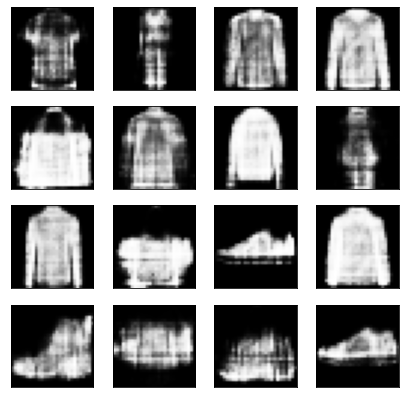

In [12]:
# randomly generated, new latent vectors
sample_size=20
rand_z = np.random.uniform(-1, 1, size=(sample_size, g_input_dim))
rand_z = torch.from_numpy(rand_z).float().to(device)

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)
view_samples(0, [rand_images])